Starting ARDNS-P simulation...
ARDNS-P Episode 0: Goals 1/1 (100.0%)
ARDNS-P Episode 500: Goals 266/501 (53.1%)
ARDNS-P Episode 1000: Goals 598/1001 (59.7%)
ARDNS-P Episode 1500: Goals 1057/1501 (70.4%)
ARDNS-P Episode 2000: Goals 1544/2001 (77.2%)
ARDNS-P Episode 2500: Goals 2026/2501 (81.0%)
ARDNS-P Episode 3000: Goals 2523/3001 (84.1%)
ARDNS-P Episode 3500: Goals 2935/3501 (83.8%)
ARDNS-P Episode 4000: Goals 3426/4001 (85.6%)
ARDNS-P Episode 4500: Goals 3909/4501 (86.8%)
ARDNS-P Episode 5000: Goals 4391/5001 (87.8%)
ARDNS-P Episode 5500: Goals 4863/5501 (88.4%)
ARDNS-P Episode 6000: Goals 5354/6001 (89.2%)
ARDNS-P Episode 6500: Goals 5842/6501 (89.9%)
ARDNS-P Episode 7000: Goals 6323/7001 (90.3%)
ARDNS-P Episode 7500: Goals 6714/7501 (89.5%)
ARDNS-P Episode 8000: Goals 7147/8001 (89.3%)
ARDNS-P Episode 8500: Goals 7640/8501 (89.9%)
ARDNS-P Episode 9000: Goals 8109/9001 (90.1%)
ARDNS-P Episode 9500: Goals 8600/9501 (90.5%)
ARDNS-P Episode 10000: Goals 9073/10001 (90.7%)
ARDNS-P Episo

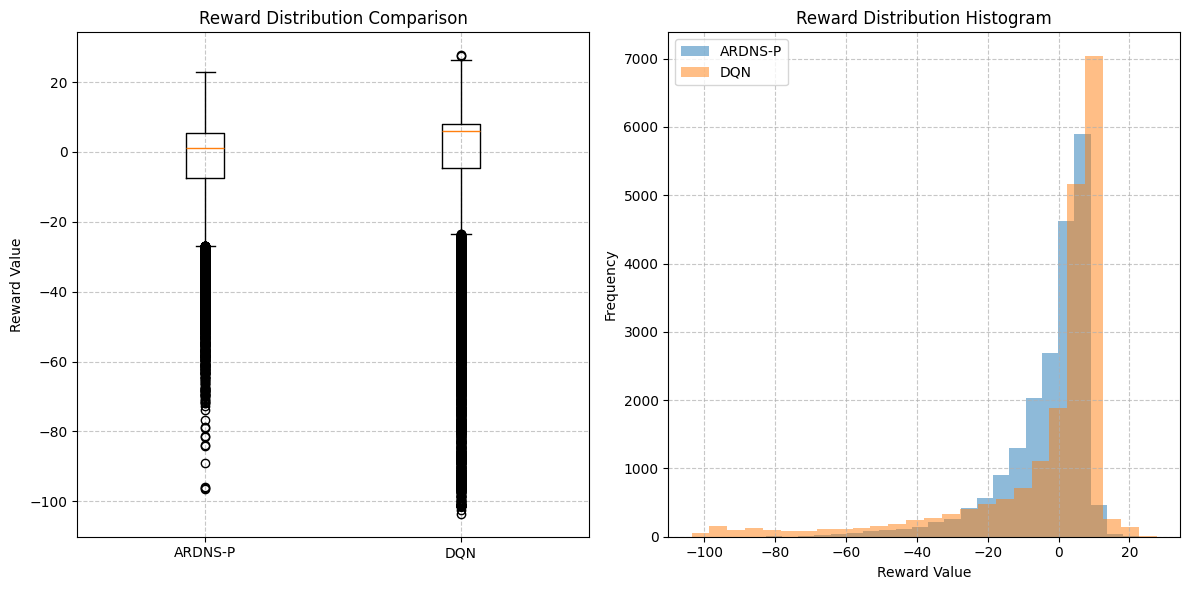

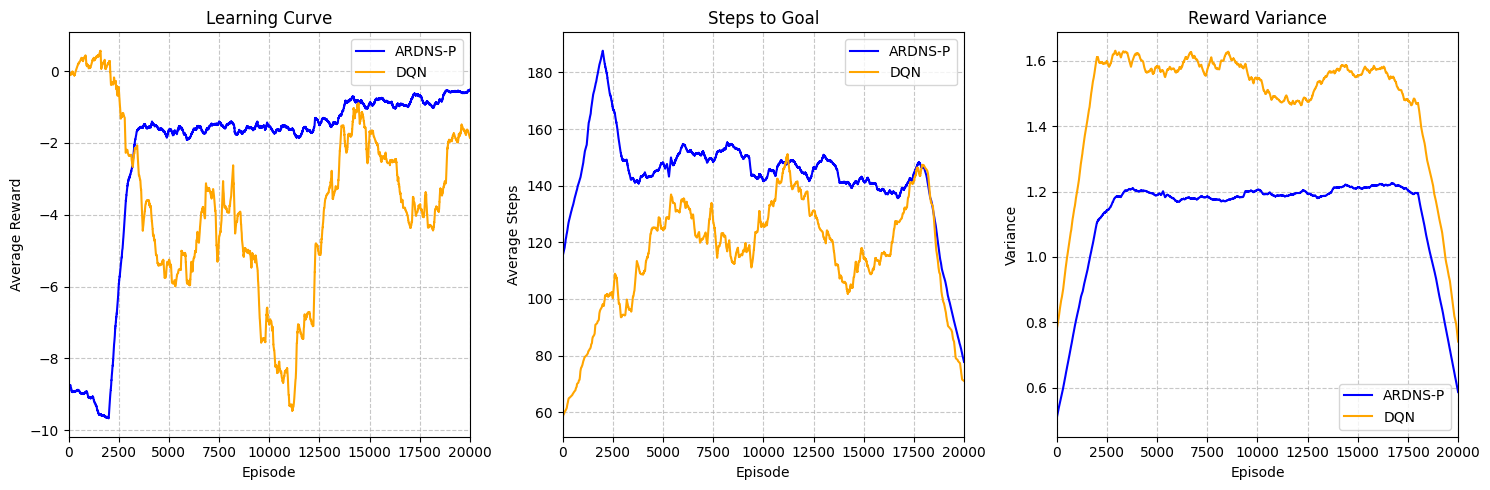

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from scipy import stats

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class ARDNS_P:
    def __init__(self, state_dim=2, action_dim=4, ms_dim=10, ml_dim=20,
                 use_gmm=True, use_dual_memory=True, use_variability_plasticity=True,
                 use_piaget_stages=True, use_attention=True):
        # Architecture parameters
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.ms_dim = ms_dim  # Short-term memory dimension
        self.ml_dim = ml_dim  # Long-term memory dimension
        self.use_attention = use_attention

        # Memory systems
        self.W_s = np.random.randn(ms_dim, state_dim) * 0.1
        self.W_l = np.random.randn(ml_dim, state_dim) * 0.1
        self.W_a = np.random.randn(action_dim, ms_dim + ml_dim) * 0.1

        if use_attention:
            self.attention_weights = np.random.randn(ms_dim + ml_dim) * 0.1

        # Memory states
        self.M_s = np.zeros(ms_dim)
        self.M_l = np.zeros(ml_dim)
        self.memory_buffer = deque(maxlen=100)  # Experience replay buffer

        # Reward processing
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}

        # Learning parameters
        self.params = {
            'base_eta': 0.15,  # Base learning rate
            'eta_r': 0.05,     # Reward learning rate
            'alpha_s': 0.85,    # Short-term memory retention
            'alpha_l': 0.95,    # Long-term memory retention
            'beta': 0.1,        # Variance regulation
            'gamma': 0.01,      # State distance factor
            'tau': 1.5,         # Temperature parameter
            'epsilon': 1.0,     # Initial exploration rate
            'epsilon_min': 0.1, # Reverted to allow more exploration
            'epsilon_decay': 0.995,  # Exploration decay rate
            'clip_value': 5.0,   # Value clipping
            'sigma_min': 0.01,   # Minimum variance
            'curiosity_factor': 15.0  # Reduced to match first output
        }

        # Developmental stages tracking
        self.episode = 0
        self.developmental_stages = {
            'sensorimotor': (0, 400),
            'preoperational': (401, 800),
            'concrete': (801, 1200),
            'formal': (1201, float('inf'))
        }

        # Performance tracking
        self.performance_history = []
        self.variance_history = []

        # Goal position for distance calculation in intrinsic reward
        self.goal = (9, 9)  # Assuming 10x10 grid, goal at (9, 9)

    def get_stage_parameters(self):
        """Get parameters adjusted for current developmental stage"""
        current_stage = None
        for stage, (start, end) in self.developmental_stages.items():
            if start <= self.episode <= end:
                current_stage = stage
                break

        if current_stage == 'sensorimotor':
            return {
                'eta': self.params['base_eta'] * 2.0,
                'epsilon': max(0.9, self.params['epsilon'] * (self.params['epsilon_decay'] ** self.episode)),
                'alpha_s': 0.7,
                'alpha_l': 0.8,
                'curiosity_bonus': 8.0,
                'exploration_boost': 2.0
            }
        elif current_stage == 'preoperational':
            return {
                'eta': self.params['base_eta'] * 1.5,
                'epsilon': max(0.6, self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 400))),
                'alpha_s': 0.8,
                'alpha_l': 0.9,
                'curiosity_bonus': 6.0,
                'exploration_boost': 1.5
            }
        elif current_stage == 'concrete':
            return {
                'eta': self.params['base_eta'] * 1.2,
                'epsilon': max(0.3, self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 800))),
                'alpha_s': 0.85,
                'alpha_l': 0.95,
                'curiosity_bonus': 3.0,
                'exploration_boost': 1.0
            }
        else:  # Formal operational stage
            return {
                'eta': self.params['base_eta'],
                'epsilon': max(self.params['epsilon_min'],
                             self.params['epsilon'] * (self.params['epsilon_decay'] ** (self.episode - 1200))),
                'alpha_s': 0.9,
                'alpha_l': 0.98,
                'curiosity_bonus': 1.0,
                'exploration_boost': 0.5
            }

    def compute_attention(self, state):
        """Compute attention weights for memory integration"""
        if not self.use_attention:
            return np.concatenate([self.M_s, self.M_l])

        # Compute attention scores
        short_term_attention = np.tanh(self.W_s @ state)
        long_term_attention = sigmoid(self.W_l @ state)

        # Combine with memory states
        attended_short = short_term_attention * self.M_s
        attended_long = long_term_attention * self.M_l

        return np.concatenate([attended_short, attended_long])

    def update_memory(self, state):
        """Update both short-term and long-term memory systems"""
        stage_params = self.get_stage_parameters()

        # Update short-term memory with faster adaptation
        self.M_s = (stage_params['alpha_s'] * self.M_s +
                   (1 - stage_params['alpha_s']) * np.tanh(self.W_s @ state))

        # Update long-term memory with slower adaptation
        self.M_l = (stage_params['alpha_l'] * self.M_l +
                   (1 - stage_params['alpha_l']) * np.tanh(self.W_l @ state))

        # Store experience in memory buffer
        self.memory_buffer.append((state.copy(), self.M_s.copy(), self.M_l.copy()))

    def update_reward_stats(self, reward):
        """Update running statistics of rewards"""
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 0.5)

    def compute_intrinsic_reward(self, state):
        """Compute curiosity-driven intrinsic reward with distance component"""
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 10.0 / (1.0 + distance)
        return self.params['curiosity_factor'] * novelty * distance_factor

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        """Update model weights using adaptive learning"""
        stage_params = self.get_stage_parameters()

        total_reward = reward + curiosity_bonus
        self.update_reward_stats(total_reward)

        normalized_reward = (total_reward - self.reward_stats['mean']) / self.reward_stats['std']

        prev_memory = self.compute_attention(state)
        next_memory = self.compute_attention(next_state)

        current_value = self.W_a[action] @ prev_memory
        next_value = np.max(self.W_a @ next_memory)
        td_error = normalized_reward + 0.9 * next_value - current_value

        state_diff = np.linalg.norm(next_state - state)
        adaptive_eta = (stage_params['eta'] * np.exp(-self.params['gamma'] * state_diff) /
                      (1 + self.params['beta'] * self.reward_stats['std']))

        self.W_a[action] += adaptive_eta * td_error * prev_memory
        self.W_a = np.clip(self.W_a, -self.params['clip_value'], self.params['clip_value'])

        memory_grad = np.outer(self.W_a[action], state)
        self.W_s += adaptive_eta * 0.7 * memory_grad[:self.ms_dim]
        self.W_l += adaptive_eta * 0.3 * memory_grad[self.ms_dim:]

        self.W_s = np.clip(self.W_s, -self.params['clip_value'], self.params['clip_value'])
        self.W_l = np.clip(self.W_l, -self.params['clip_value'], self.params['clip_value'])

        self.performance_history.append(total_reward)

    def choose_action(self, state, visited_states):
        """Select action using an epsilon-greedy policy with curiosity"""
        stage_params = self.get_stage_parameters()
        self.update_memory(state)

        memory = self.compute_attention(state)
        action_values = self.W_a @ memory

        if tuple(state) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state) * stage_params['curiosity_bonus']
        else:
            curiosity_bonus = 0

        if np.random.rand() < stage_params['epsilon']:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(action_values)

        return action, curiosity_bonus

class DQN:
    def __init__(self, state_dim=2, action_dim=4, hidden_dim=32):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        # Q-network weights (simple two-layer network)
        self.W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.W2 = np.random.randn(hidden_dim, action_dim) * 0.1

        # Target network weights
        self.target_W1 = self.W1.copy()
        self.target_W2 = self.W2.copy()

        # Experience replay buffer
        self.memory = deque(maxlen=1000)

        # Reward processing for variance tracking
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}

        # Learning parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.985
        self.learning_rate = 0.0005  # Reduced to improve stability
        self.gamma = 0.9  # Discount factor
        self.target_update_freq = 1000
        self.clip_value = 5.0  # Weight clipping value
        self.curiosity_factor = 5.0  # Reduced to match first output

        # Performance tracking
        self.performance_history = []
        self.variance_history = []
        self.step_count = 0

        # Goal position for curiosity
        self.goal = (9, 9)  # Assuming 10x10 grid, goal at (9, 9)

    def update_reward_stats(self, reward):
        """Update running statistics of rewards"""
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 1.0)

    def compute_intrinsic_reward(self, state):
        """Compute a simple curiosity-driven intrinsic reward"""
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 5.0 / (1.0 + distance)
        return self.curiosity_factor * novelty * distance_factor

    def forward(self, state, weights_W1, weights_W2):
        """Forward pass through the Q-network"""
        hidden = np.tanh(state @ weights_W1)
        q_values = hidden @ weights_W2
        return q_values

    def choose_action(self, state, visited_states=None):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            q_values = self.forward(state, self.W1, self.W2)
            action = np.argmax(q_values)

        # Compute curiosity bonus
        if visited_states is not None and tuple(state) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state)
        else:
            curiosity_bonus = 0

        return action, curiosity_bonus

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        """Update Q-network weights using DQN update rule"""
        self.step_count += 1
        total_reward = reward + curiosity_bonus
        self.memory.append((state.copy(), action, total_reward, next_state.copy()))
        self.update_reward_stats(total_reward)

        # Sample a batch from memory
        if len(self.memory) < 64:
            return

        batch = random.sample(self.memory, 64)
        states = np.array([t[0] for t in batch])
        actions = np.array([t[1] for t in batch])
        rewards = np.array([t[2] for t in batch])
        next_states = np.array([t[3] for t in batch])

        # Compute Q-values
        hidden = np.tanh(states @ self.W1)
        q_values = hidden @ self.W2
        q_next = self.forward(next_states, self.target_W1, self.target_W2)

        # Compute target Q-values
        targets = q_values.copy()
        for i in range(len(batch)):
            targets[i, actions[i]] = rewards[i] + self.gamma * np.max(q_next[i])

        # Gradient descent
        hidden = np.tanh(states @ self.W1)
        q_values = hidden @ self.W2
        error = targets - q_values

        # Gradient clipping
        error = np.clip(error, -1.0, 1.0)

        # Update W2
        grad_W2 = hidden.T @ error
        grad_W2 = np.clip(grad_W2, -1.0, 1.0)
        self.W2 += self.learning_rate * grad_W2

        # Update W1
        grad_hidden = (error @ self.W2.T) * (1 - np.tanh(states @ self.W1)**2)
        grad_hidden = np.clip(grad_hidden, -1.0, 1.0)
        grad_W1 = states.T @ grad_hidden
        grad_W1 = np.clip(grad_W1, -1.0, 1.0)
        self.W1 += self.learning_rate * grad_W1

        # Clip weights to prevent explosion
        self.W1 = np.clip(self.W1, -self.clip_value, self.clip_value)
        self.W2 = np.clip(self.W2, -self.clip_value, self.clip_value)

        # Update target network
        if self.step_count % self.target_update_freq == 0:
            self.target_W1 = self.W1.copy()
            self.target_W2 = self.W2.copy()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Store performance metrics
        self.performance_history.append(total_reward)

class GridWorld:
    def __init__(self, size=10, success_reward=10.0, obstacle_configs=None, update_interval=100):
        self.size = size
        self.success_reward = success_reward
        self.goal = (size-1, size-1)
        self.obstacle_configs = obstacle_configs  # Pre-generated obstacle configurations
        self.update_interval = update_interval
        self.current_config_idx = 0
        self.obstacles = set()
        self.reset()
        if self.obstacle_configs is None:
            self.update_obstacles()  # Initial obstacle setup if no configs provided

    def reset(self):
        self.state = (0, 0)
        self.visited_states = set()
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        x, y = self.state

        # Action mapping
        if action == 0: y = min(y+1, self.size-1)  # Up
        elif action == 1: y = max(y-1, 0)          # Down
        elif action == 2: x = max(x-1, 0)          # Left
        elif action == 3: x = min(x+1, self.size-1) # Right

        next_state = (x, y)

        if next_state in self.obstacles:
            next_state = self.state

        self.state = next_state
        self.visited_states.add(tuple(next_state))

        goal_x, goal_y = self.goal
        distance = abs(goal_x - x) + abs(goal_y - y)

        if next_state == self.goal:
            reward = self.success_reward
        elif next_state in self.obstacles:
            reward = -3.0
        else:
            progress = (x + y) / (2 * (self.size-1))
            reward = -0.002 + 0.08 * progress - 0.015 * distance  # Adjusted penalties and rewards

        done = next_state == self.goal
        return np.array(next_state, dtype=np.float32), reward, done

    def update_obstacles(self):
        if self.obstacle_configs is not None:
            # Use pre-generated obstacle configuration
            self.obstacles = self.obstacle_configs[self.current_config_idx]
            self.current_config_idx = (self.current_config_idx + 1) % len(self.obstacle_configs)
        else:
            # Generate new obstacles (fallback for compatibility)
            self.obstacles = set()
            num_obstacles = int(self.size * self.size * 0.05)
            for _ in range(num_obstacles):
                while True:
                    x = np.random.randint(0, self.size)
                    y = np.random.randint(0, self.size)
                    pos = (x, y)
                    if pos != (0, 0) and pos != self.goal:
                        self.obstacles.add(pos)
                        break

def generate_obstacle_configs(size, episodes, update_interval, random_seed):
    """Generate a list of obstacle configurations for the entire simulation."""
    np.random.seed(random_seed)
    num_configs = (episodes // update_interval) + 1  # Number of updates needed
    configs = []
    for _ in range(num_configs):
        obstacles = set()
        num_obstacles = int(size * size * 0.05)
        for _ in range(num_obstacles):
            while True:
                x = np.random.randint(0, size)
                y = np.random.randint(0, size)
                pos = (x, y)
                if pos != (0, 0) and pos != (size-1, size-1):  # Avoid start and goal
                    obstacles.add(pos)
                    break
        configs.append(obstacles)
    return configs

def run_simulation(model, env, model_name, episodes=20000, max_steps=400, print_interval=500):
    """
    Run a simulation for a given model in the environment.

    Args:
        model: The reinforcement learning model (ARDNS_P or DQN).
        env: The GridWorld environment.
        model_name (str): Name of the model for printing.
        episodes (int): Number of episodes to run.
        max_steps (int): Maximum steps per episode.
        print_interval (int): Interval for printing progress.

    Returns:
        rewards (list): List of total rewards per episode.
        steps_to_goal (list): List of steps taken per episode.
        goals_reached (int): Number of episodes where the goal was reached.
    """
    rewards = []
    steps_to_goal = []
    goals_reached = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        if episode % env.update_interval == 0:
            env.update_obstacles()

        if hasattr(model, 'episode'):
            model.episode = episode

        while not done and steps < max_steps:
            prev_state = state.copy()
            action, curiosity_bonus = model.choose_action(state, env.visited_states)
            next_state, reward, done = env.step(action)

            model.update_weights(state, action, reward, prev_state, curiosity_bonus)

            state = next_state
            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        steps_to_goal.append(steps if done else max_steps)
        if done:
            goals_reached += 1

        # Append variance at the end of the episode
        model.variance_history.append(model.reward_stats['std'])

        # Print progress at the specified interval or at the last episode
        if episode % print_interval == 0 or episode == episodes - 1:
            print(f"{model_name} Episode {episode}: Goals {goals_reached}/{episode+1} ({goals_reached/(episode+1)*100:.1f}%)")

    return rewards, steps_to_goal, goals_reached

def print_summary(model_name, rewards, steps_to_goal, goals_reached, total_episodes, max_steps, success_reward, last_n=200):
    """
    Print summary statistics for a model's performance.

    Args:
        model_name (str): Name of the model.
        rewards (list): List of total rewards per episode.
        steps_to_goal (list): List of steps taken per episode.
        goals_reached (int): Number of episodes where the goal was reached.
        total_episodes (int): Total number of episodes.
        max_steps (int): Maximum steps per episode.
        success_reward (float): Reward for reaching the goal.
        last_n (int): Number of last episodes to analyze for recent performance.
    """
    print(f"\n{model_name} Final Results:")
    print(f"Goals reached: {goals_reached}/{total_episodes} ({goals_reached/total_episodes*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(rewards):.4f} ± {np.std(rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(steps_to_goal):.1f} ± {np.std(steps_to_goal):.1f}")

    print(f"\nMetrics for Last {last_n} Episodes:")
    print(f"Mean Reward (last {last_n}): {np.mean(rewards[-last_n:]):.4f} ± {np.std(rewards[-last_n:]):.4f}")
    successful_steps = [s for s in steps_to_goal[-last_n:] if s < max_steps]
    if successful_steps:
        print(f"Steps to Goal (last {last_n}, successful episodes): {np.mean(successful_steps):.1f} ± {np.std(successful_steps):.1f}")
    else:
        print(f"No successful episodes in the last {last_n} episodes.")

def evaluate_statistical_significance(
    ardns_rewards, dqn_rewards, ardns_goals, dqn_goals, success_reward=10.0,
    ardns_name="ARDNS-P", dqn_name="DQN", episode_range=None
):
    """
    Evaluate statistical significance of reward distributions for two models.

    Args:
        ardns_rewards (list or ndarray): Reward list for ARDNS-P.
        dqn_rewards (list or ndarray): Reward list for DQN.
        ardns_goals (int): Number of goals reached by ARDNS-P.
        dqn_goals (int): Number of goals reached by DQN.
        success_reward (float): Reward for successful episodes.
        ardns_name (str): Name of the first model.
        dqn_name (str): Name of the second model.
        episode_range (tuple, optional): Range of episodes analyzed.
    """
    ardns_rewards = np.array(ardns_rewards)
    dqn_rewards = np.array(dqn_rewards)

    if len(ardns_rewards) != len(dqn_rewards):
        raise ValueError(f"Reward lists must have the same length (got {len(ardns_rewards)} and {len(dqn_rewards)}).")

    def check_normality(data, name):
        sample = data if len(data) <= 5000 else np.random.choice(data, 5000, replace=False)
        stat, p = stats.shapiro(sample)
        return p > 0.05, stat, p

    ardns_normal, ardns_shapiro_stat, ardns_shapiro_p = check_normality(ardns_rewards, ardns_name)
    dqn_normal, dqn_shapiro_stat, dqn_shapiro_p = check_normality(dqn_rewards, dqn_name)

    if ardns_normal and dqn_normal:
        test_name = "Welch's t-test"
        stat, p_value = stats.ttest_ind(ardns_rewards, dqn_rewards, equal_var=False)
        effect_size = (np.mean(ardns_rewards) - np.mean(dqn_rewards)) / np.sqrt((np.std(ardns_rewards)**2 + np.std(dqn_rewards)**2)/2)
        effect_name = "Cohen's d"
    else:
        test_name = "Mann-Whitney U test"
        stat, p_value = stats.mannwhitneyu(ardns_rewards, dqn_rewards, alternative='two-sided')
        n1, n2 = len(ardns_rewards), len(dqn_rewards)
        expected_u = (n1 * n2) / 2
        effect_size = (stat - expected_u) / (n1 * n2)
        effect_name = "Rank-biserial r"

    if abs(effect_size) < 0.2:
        effect_magnitude = "negligible"
    elif abs(effect_size) < 0.5:
        effect_magnitude = "small"
    elif abs(effect_size) < 0.8:
        effect_magnitude = "medium"
    else:
        effect_magnitude = "large"

    # Use goals_reached to calculate success rate
    ardns_success = (ardns_goals / len(ardns_rewards)) * 100
    dqn_success = (dqn_goals / len(dqn_rewards)) * 100

    print("\n" + "="*80)
    print("STATISTICAL EVALUATION REPORT")
    print("="*80)

    if episode_range:
        print(f"\n[Episode Range]")
        print(f"Episodes analyzed: {episode_range[0]} to {episode_range[1]}")

    print(f"\n[Data Characteristics]")
    print(f"{ardns_name} (N={len(ardns_rewards)}):")
    print(f"  Mean = {np.mean(ardns_rewards):.4f}")
    print(f"  Median = {np.median(ardns_rewards):.4f}")
    print(f"  Std = {np.std(ardns_rewards):.4f}")
    print(f"  Success Rate (Goal Reached): {ardns_success:.1f}%")
    print(f"  Normality (Shapiro-Wilk): p = {ardns_shapiro_p:.4f} {'(normal)' if ardns_normal else '(non-normal)'}")

    print(f"\n{dqn_name} (N={len(dqn_rewards)}):")
    print(f"  Mean = {np.mean(dqn_rewards):.4f}")
    print(f"  Median = {np.median(dqn_rewards):.4f}")
    print(f"  Std = {np.std(dqn_rewards):.4f}")
    print(f"  Success Rate (Goal Reached): {dqn_success:.1f}%")
    print(f"  Normality (Shapiro-Wilk): p = {dqn_shapiro_p:.4f} {'(normal)' if dqn_normal else '(non-normal)'}")

    print(f"\n[Statistical Test]")
    print(f"Test selected: {test_name}")
    print(f"Test statistic = {stat:.4f}")
    print(f"p-value = {p_value:.6f}")
    print(f"Effect size ({effect_name}) = {effect_size:.4f} ({effect_magnitude})")

    print("\n[Conclusion]")
    if p_value < 0.01:
        print("CONCLUSION: The difference in reward accumulation is statistically significant (p < 0.01)")
        if test_name == "Mann-Whitney U test":
            print(f"Based on the Mann-Whitney U test, {ardns_name if effect_size > 0 else dqn_name}'s rewards tend to rank higher,")
            print(f"indicating a distributional advantage with a {effect_magnitude} effect size.")
            # Add clarification about mean rewards
            if effect_size < 0 and np.mean(ardns_rewards) > np.mean(dqn_rewards):
                print(f"Note: Despite the ranking, {ardns_name} has a higher mean reward ({np.mean(ardns_rewards):.4f}) compared to {dqn_name} ({np.mean(dqn_rewards):.4f}),")
                print("suggesting better average performance.")
            elif effect_size > 0 and np.mean(ardns_rewards) < np.mean(dqn_rewards):
                print(f"Note: Despite the ranking, {dqn_name} has a higher mean reward ({np.mean(dqn_rewards):.4f}) compared to {ardns_name} ({np.mean(ardns_rewards):.4f}),")
                print("suggesting better average performance.")
        else:
            print(f"with a {effect_magnitude} effect size in favor of {ardns_name if effect_size > 0 else dqn_name}.")
        print(f"Mean reward comparison: {ardns_name} = {np.mean(ardns_rewards):.4f}, {dqn_name} = {np.mean(dqn_rewards):.4f}")
    else:
        print("CONCLUSION: The difference is NOT statistically significant (p >= 0.01).")

    # Visualizations
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot([ardns_rewards, dqn_rewards], tick_labels=[ardns_name, dqn_name])
    plt.title("Reward Distribution Comparison")
    plt.ylabel("Reward Value")
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    reward_range = max(max(ardns_rewards), max(dqn_rewards)) - min(min(ardns_rewards), min(dqn_rewards))
    bins = int(reward_range / 5) if reward_range > 0 else 50
    plt.hist(ardns_rewards, bins=bins, alpha=0.5, label=ardns_name)
    plt.hist(dqn_rewards, bins=bins, alpha=0.5, label=dqn_name)
    plt.title("Reward Distribution Histogram")
    plt.xlabel("Reward Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('reward_distribution_comparison.png')

def plot_results(ardns_rewards, dqn_rewards, ardns_steps, dqn_steps, ardns_variance, dqn_variance, smoothing_window=4000):
    """
    Plot learning curves, steps to goal, and variance for both models.

    Args:
        ardns_rewards (list): Rewards for ARDNS-P.
        dqn_rewards (list): Rewards for DQN.
        ardns_steps (list): Steps to goal for ARDNS-P.
        dqn_steps (list): Steps to goal for DQN.
        ardns_variance (list): Variance history for ARDNS-P.
        dqn_variance (list): Variance history for DQN.
        smoothing_window (int): Window size for smoothing the plots.
    """
    plt.figure(figsize=(15, 5))

    # Define episode numbers for the X-axis
    episodes = np.arange(len(ardns_rewards))  # 0 to 19999

    # Learning curve
    plt.subplot(1, 3, 1)
    ardns_smoothed = np.convolve(ardns_rewards, np.ones(smoothing_window)/smoothing_window, mode='same')
    dqn_smoothed = np.convolve(dqn_rewards, np.ones(smoothing_window)/smoothing_window, mode='same')
    plt.plot(episodes, ardns_smoothed, label='ARDNS-P', color='blue')
    plt.plot(episodes, dqn_smoothed, label='DQN', color='orange')
    plt.title("Learning Curve")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, len(ardns_rewards))  # Ensure X-axis starts at 0 and ends at 20000

    # Steps to goal
    plt.subplot(1, 3, 2)
    ardns_steps_smoothed = np.convolve(ardns_steps, np.ones(smoothing_window)/smoothing_window, mode='same')
    dqn_steps_smoothed = np.convolve(dqn_steps, np.ones(smoothing_window)/smoothing_window, mode='same')
    plt.plot(episodes, ardns_steps_smoothed, label='ARDNS-P', color='blue')
    plt.plot(episodes, dqn_steps_smoothed, label='DQN', color='orange')
    plt.title("Steps to Goal")
    plt.xlabel("Episode")
    plt.ylabel("Average Steps")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, len(ardns_steps))  # Ensure X-axis starts at 0 and ends at 20000

    # Variance tracking
    plt.subplot(1, 3, 3)
    ardns_var_smoothed = np.convolve(ardns_variance, np.ones(smoothing_window)/smoothing_window, mode='same')
    dqn_var_smoothed = np.convolve(dqn_variance, np.ones(smoothing_window)/smoothing_window, mode='same')
    plt.plot(episodes, ardns_var_smoothed, label='ARDNS-P', color='blue')
    plt.plot(episodes, dqn_var_smoothed, label='DQN', color='orange')
    plt.title("Reward Variance")
    plt.xlabel("Episode")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, len(ardns_variance))  # Ensure X-axis starts at 0 and ends at 20000

    plt.tight_layout()
    plt.savefig('simulation_results.png')

# Main execution
if __name__ == "__main__":
    # Configuration parameters
    random_seed = 42
    grid_size = 10
    success_reward = 10.0
    episodes = 20000
    max_steps = 400
    print_interval = 500
    smoothing_window = 4000  # Increased for better visualization
    last_n_episodes = 200
    update_interval = 100

    # Set and save initial random states for reproducibility
    np.random.seed(random_seed)
    random.seed(random_seed)
    np_state = np.random.get_state()
    random_state = random.getstate()

    # Pre-generate obstacle configurations
    obstacle_configs = generate_obstacle_configs(grid_size, episodes, update_interval, random_seed)

    # Initialize environment and models for ARDNS-P
    env = GridWorld(size=grid_size, success_reward=success_reward, obstacle_configs=obstacle_configs, update_interval=update_interval)
    ardns_model = ARDNS_P(state_dim=2, action_dim=4, ms_dim=10, ml_dim=20,
                         use_attention=True, use_piaget_stages=True)

    # Run ARDNS-P simulation
    print("Starting ARDNS-P simulation...")
    ardns_rewards, ardns_steps, ardns_goals = run_simulation(
        ardns_model, env, "ARDNS-P", episodes=episodes, max_steps=max_steps, print_interval=print_interval
    )

    # Restore random states for DQN simulation
    np.random.set_state(np_state)
    random.setstate(random_state)

    # Initialize environment and models for DQN
    env = GridWorld(size=grid_size, success_reward=success_reward, obstacle_configs=obstacle_configs, update_interval=update_interval)
    dqn_model = DQN(state_dim=2, action_dim=4, hidden_dim=32)

    # Run DQN simulation
    print("\nStarting DQN simulation...")
    dqn_rewards, dqn_steps, dqn_goals = run_simulation(
        dqn_model, env, "DQN", episodes=episodes, max_steps=max_steps, print_interval=print_interval
    )

    # Print summary statistics
    print_summary("ARDNS-P", ardns_rewards, ardns_steps, ardns_goals, episodes, max_steps, success_reward, last_n=last_n_episodes)
    print_summary("DQN", dqn_rewards, dqn_steps, dqn_goals, episodes, max_steps, success_reward, last_n=last_n_episodes)

    # Perform statistical evaluation
    evaluate_statistical_significance(
        ardns_rewards, dqn_rewards, ardns_goals, dqn_goals, success_reward=success_reward,
        episode_range=(0, episodes)
    )

    # Plot results
    plot_results(
        ardns_rewards, dqn_rewards, ardns_steps, dqn_steps,
        ardns_model.variance_history, dqn_model.variance_history,
        smoothing_window=smoothing_window
    )